In [10]:
!pip install pyarrow
!pip uninstall -y numpy
!pip uninstall -y setuptools
!pip install setuptools==39.1.0
!pip install numpy

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Found existing installation: numpy 1.24.2
Uninstalling numpy-1.24.2:
  Successfully uninstalled numpy-1.24.2
Found existing installation: setuptools 67.5.1
Uninstalling setuptools-67.5.1:
  Successfully uninstalled setuptools-67.5.1
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Using cached setuptools-39.1.0-py2.py3-none-any.whl (566 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.1.6 requires numpy>=1.15.0, which is not installed.
tensorflow 2.11.0 requires numpy>=1.20, which is not installed.
tensorboard 2.11.2 requires numpy>=1.12.0, which is not installed.
spacy 3.4.4 requires numpy>=1.15.0, which is not installed.
numba 0.56.4 requires numpy<1.24,>=1.18, which is not installed.
hdijupyterutils 0.20.3 requires numpy>=1.16.5

In [11]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Using cached setuptools-67.5.1-py3-none-any.whl (1.1 MB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 39.1.0
    Uninstalling setuptools-39.1.0:
      Successfully uninstalled setuptools-39.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.2 which is incompatible.


In [22]:
import torch
from torch.autograd import Variable

import s3fs
from pyarrow.parquet import ParquetDataset
import io
import re
import string
import tqdm
import numpy as np
import pandas as pd

import tensorflow as tf

import random
import os, errno
import sys
from tqdm import trange

import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [23]:
data = pd.read_parquet('Op_Log_masked_v2.parquet')

In [24]:
data.head()

,id,operation,user_id,request_time,country_code,vip_level,nationality_country_code
0,3209645159566664705,901259b15f2f4a3ec231d501f327fcbf1961b74e9a6021...,5cf197e2af57aa39f280082c44056cd887190e0cf03046...,2022-11-24 05:35:59,293650de072648b9e2790509d8109d0f34f655edfe0b20...,5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91...,293650de072648b9e2790509d8109d0f34f655edfe0b20...
1,3213249757854087425,901259b15f2f4a3ec231d501f327fcbf1961b74e9a6021...,5cf197e2af57aa39f280082c44056cd887190e0cf03046...,2022-11-26 17:16:50,293650de072648b9e2790509d8109d0f34f655edfe0b20...,5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91...,293650de072648b9e2790509d8109d0f34f655edfe0b20...
2,3211070210680190465,901259b15f2f4a3ec231d501f327fcbf1961b74e9a6021...,5cf197e2af57aa39f280082c44056cd887190e0cf03046...,2022-11-25 05:11:39,293650de072648b9e2790509d8109d0f34f655edfe0b20...,5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91...,293650de072648b9e2790509d8109d0f34f655edfe0b20...
3,3211660966921795072,901259b15f2f4a3ec231d501f327fcbf1961b74e9a6021...,5cf197e2af57aa39f280082c44056cd887190e0cf03046...,2022-11-25 14:53:29,293650de072648b9e2790509d8109d0f34f655edfe0b20...,5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91...,293650de072648b9e2790509d8109d0f34f655edfe0b20...
4,801512741519622145,d96eada60d4986ffe49624104bec7e6506306cff52ea53...,5cf197e2af57aa39f280082c44056cd887190e0cf03046...,2022-11-21 18:05:29,293650de072648b9e2790509d8109d0f34f655edfe0b20...,5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91...,293650de072648b9e2790509d8109d0f34f655edfe0b20...


In [25]:
print("There are " + str(data['operation'].nunique()) + " types of operations!")
print("Dataframe shape is " + str(data.shape))

There are 249 types of operations!
Dataframe shape is (240178, 7)


In [26]:
# filter out 1-operation users (non-sequential data)

user_counts = data['user_id'].value_counts().reset_index()
bottom_users = user_counts[user_counts['user_id']<=1]
bottom_users = bottom_users['index'].tolist()
data = data[~data['user_id'].isin(bottom_users)] 
data['request_time'] = pd.to_datetime(data['request_time'], format='%Y-%m-%d %H:%M:%S')
data = data.sort_values(by=['request_time'])
print("Dataframe shape after filtering out singular operations is " + str(data.shape))

Dataframe shape after filtering out singular operations is (240157, 7)


In [17]:
print("There are " + str(data['operation'].nunique()) + " types of operations!")

There are 249 types of operations!


# Data Visualization

In [27]:
data['operation'].value_counts().reset_index().describe()

,operation
count,249.000000
mean,964.485944
std,4971.370761
min,1.000000
25%,7.000000
50%,37.000000
75%,190.000000
max,70931.000000


In [28]:
data['user_id'].value_counts().reset_index().describe()

,user_id
count,6726.000000
mean,35.705769
std,111.497402
min,2.000000
25%,6.000000
50%,11.000000
75%,24.000000
max,4707.000000


<AxesSubplot:xlabel='user_id', ylabel='Density'>

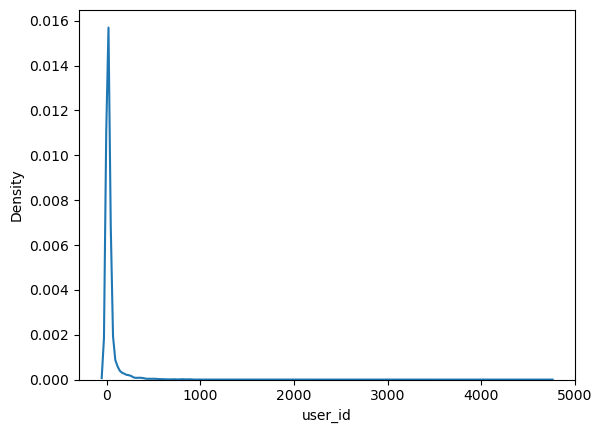

In [57]:
sns.kdeplot(data=data['user_id'].value_counts().reset_index(), x="user_id")

<AxesSubplot:xlabel='operation', ylabel='Density'>

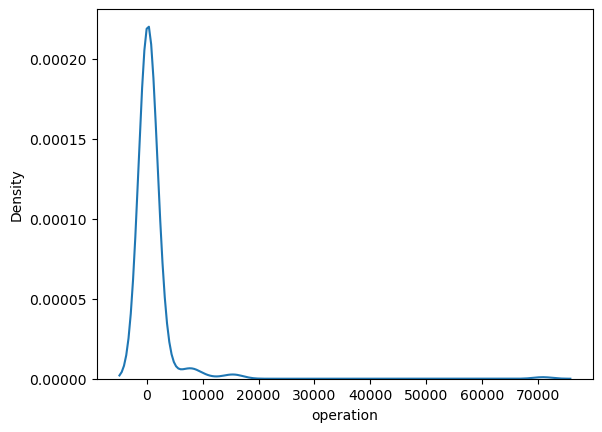

In [60]:
sns.kdeplot(data=data['operation'].value_counts().reset_index(), x="operation")

<AxesSubplot:xlabel='user_id', ylabel='count'>

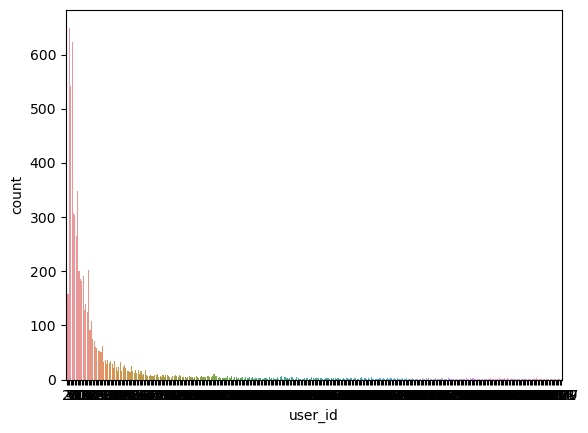

In [56]:
import seaborn as sns
#sns.countplot(x='operation', data=data['operation'].value_counts().reset_index())
sns.countplot(x='user_id', data=data['user_id'].value_counts().reset_index())

In [53]:
data.describe()

/tmp/ipykernel_4613/3175101911.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data.describe()


,id,operation,user_id,request_time,country_code,vip_level,nationality_country_code
count,240157,240157,240157,240157,240157,240157,240157
unique,240157,249,6726,196882,151,6,130
top,3204958280035044865,901259b15f2f4a3ec231d501f327fcbf1961b74e9a6021...,9f17b164c76dac77a22cb5c11fdf094d5359410859f599...,2022-11-22 09:25:18,22ca9cf39e4466983a65465a5510483eb2b4893d228720...,5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91...,b6c90e2907dc8fb9d93affdbea104ba62784a4120cbe68...
freq,1,70931,4707,8,21817,229399,153518
first,NaN,NaN,NaN,2022-11-21 00:00:00,NaN,NaN,NaN
last,NaN,NaN,NaN,2022-11-29 23:59:45,NaN,NaN,NaN


In [18]:
# single out per user, not operations

data['country_code'].value_counts().reset_index().describe()

,country_code
count,151.000000
mean,1590.443709
std,3421.687994
min,3.000000
25%,111.000000
50%,370.000000
75%,1020.000000
max,21817.000000


In [81]:
data['vip_level'].value_counts().reset_index()

d = data[['user_id','vip_level','country_code']]

In [82]:
d = data[['user_id','vip_level','country_code']]
d = d.value_counts().reset_index()[['user_id','vip_level','country_code']].value_counts().reset_index()

In [83]:
data['user_id'].unique()

array(['af4fbc85d3670364456e24df539896413a01e4cc124f0149e0ca4a8bf77a1339',
       'a19cd0b2a27336a62e81e95030f35f9062e96093a2e62eb0620059032cd96b6f',
       '6265092de58f4217ea206ecac629ea0a9d6026ebe3b558d187539e190b3e0909',
       ...,
       'af86cd5e2655a181074b0be0f845117c8284e473f720ba22ac74948b2d1e53de',
       '96a1505ffc0f6cfb47793531f49e367b8c47d865b8b43b698ced8101cdd0116e',
       '0d522e753d097786779a26b09675818134cb8e486f5807c991eaf7f65212eb68'],
      dtype=object)

In [84]:
d['user_id_order'] = data['user_id'].unique()
d_country = d.assign(country_code = d['user_id_order'].map(d.set_index('user_id')['country_code']), 
             user_id = d['user_id_order'])

In [85]:
d_country.head()

,user_id,vip_level,country_code,0,user_id_order
0,af4fbc85d3670364456e24df539896413a01e4cc124f01...,5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91...,9fc4508238942e7cf40354d962db0c18c5ceec7320e0a3...,1,af4fbc85d3670364456e24df539896413a01e4cc124f01...
1,a19cd0b2a27336a62e81e95030f35f9062e96093a2e62e...,5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91...,9fc4508238942e7cf40354d962db0c18c5ceec7320e0a3...,1,a19cd0b2a27336a62e81e95030f35f9062e96093a2e62e...
2,6265092de58f4217ea206ecac629ea0a9d6026ebe3b558...,5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91...,afcc3bc93518023ce2eec113ced19e43563bcc9a79b693...,1,6265092de58f4217ea206ecac629ea0a9d6026ebe3b558...
3,82c9eab64293bbf9753d979fbbbcd2d68945dfd41c227f...,5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91...,b4043b0b8297e379bc559ab33b6ae9c7a9b4ef6519d3ba...,1,82c9eab64293bbf9753d979fbbbcd2d68945dfd41c227f...
4,249125cca9006a925ecabfa28a75a5a259bac6d63bbf56...,5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91...,bb1c202965ca241975a90c4d4db43001bad7ee64ba9b44...,1,249125cca9006a925ecabfa28a75a5a259bac6d63bbf56...


In [86]:
d_vip = d.assign(vip_level = d['user_id_order'].map(d.set_index('user_id')['vip_level']), 
             user_id = d['user_id_order'])

In [87]:
d_vip.head()

,user_id,vip_level,country_code,0,user_id_order
0,af4fbc85d3670364456e24df539896413a01e4cc124f01...,5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91...,22ca9cf39e4466983a65465a5510483eb2b4893d228720...,1,af4fbc85d3670364456e24df539896413a01e4cc124f01...
1,a19cd0b2a27336a62e81e95030f35f9062e96093a2e62e...,5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91...,3843971dcfdee5083e6289e1bbdbb003e538b5a8a668fc...,1,a19cd0b2a27336a62e81e95030f35f9062e96093a2e62e...
2,6265092de58f4217ea206ecac629ea0a9d6026ebe3b558...,5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91...,bbaf8352442730e92c16c5ea6b0ff7cc595c24e02d8e8b...,1,6265092de58f4217ea206ecac629ea0a9d6026ebe3b558...
3,82c9eab64293bbf9753d979fbbbcd2d68945dfd41c227f...,5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91...,1cf587e0bafeb6195595fcbdce170411d52ea40dc4e358...,1,82c9eab64293bbf9753d979fbbbcd2d68945dfd41c227f...
4,249125cca9006a925ecabfa28a75a5a259bac6d63bbf56...,2c624232cdd221771294dfbb310aca000a0df6ac8b66b6...,576123d7a7d57a6b3bc169802313fa3026181fe8b86121...,1,249125cca9006a925ecabfa28a75a5a259bac6d63bbf56...


In [88]:
country_code = d_country['country_code']
vip_level = d_vip['vip_level']

In [91]:
print(len(set(country_code)))

151


In [90]:
import pickle

with open('vip_level', 'wb') as f:
    pickle.dump(vip_level, f) 
    
with open('country_code', 'wb') as f:
    pickle.dump(country_code, f) 

In [98]:
new_df = d_vip
new_df['country_code']=d_country['country_code']
new_df = new_df[['user_id','vip_level','country_code']]

In [99]:
new_df.head()

,user_id,vip_level,country_code
0,af4fbc85d3670364456e24df539896413a01e4cc124f01...,5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91...,9fc4508238942e7cf40354d962db0c18c5ceec7320e0a3...
1,a19cd0b2a27336a62e81e95030f35f9062e96093a2e62e...,5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91...,9fc4508238942e7cf40354d962db0c18c5ceec7320e0a3...
2,6265092de58f4217ea206ecac629ea0a9d6026ebe3b558...,5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91...,afcc3bc93518023ce2eec113ced19e43563bcc9a79b693...
3,82c9eab64293bbf9753d979fbbbcd2d68945dfd41c227f...,5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91...,b4043b0b8297e379bc559ab33b6ae9c7a9b4ef6519d3ba...
4,249125cca9006a925ecabfa28a75a5a259bac6d63bbf56...,2c624232cdd221771294dfbb310aca000a0df6ac8b66b6...,bb1c202965ca241975a90c4d4db43001bad7ee64ba9b44...


In [100]:
with open("cluster_labels", "rb") as fp:
    cluster_labels = pickle.load(fp)

In [101]:
new_df['clusters'] = cluster_labels

/tmp/ipykernel_12060/3726088441.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['clusters'] = cluster_labels


In [103]:
new_df.head()

,user_id,vip_level,country_code,clusters
0,af4fbc85d3670364456e24df539896413a01e4cc124f01...,5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91...,9fc4508238942e7cf40354d962db0c18c5ceec7320e0a3...,0
1,a19cd0b2a27336a62e81e95030f35f9062e96093a2e62e...,5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91...,9fc4508238942e7cf40354d962db0c18c5ceec7320e0a3...,0
2,6265092de58f4217ea206ecac629ea0a9d6026ebe3b558...,5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91...,afcc3bc93518023ce2eec113ced19e43563bcc9a79b693...,0
3,82c9eab64293bbf9753d979fbbbcd2d68945dfd41c227f...,5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91...,b4043b0b8297e379bc559ab33b6ae9c7a9b4ef6519d3ba...,0
4,249125cca9006a925ecabfa28a75a5a259bac6d63bbf56...,2c624232cdd221771294dfbb310aca000a0df6ac8b66b6...,bb1c202965ca241975a90c4d4db43001bad7ee64ba9b44...,-1


In [104]:
clusterminusone = new_df[new_df['clusters']==-1]
clusterone = new_df[new_df['clusters']==1]
clustertwo = new_df[new_df['clusters']==2]
clusterthree = new_df[new_df['clusters']==3]

In [118]:
print(clusterminusone['vip_level'].value_counts())
#print(clusterminusone['country_code'].value_counts())

5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91b46729d73a27fb57e9    76
2c624232cdd221771294dfbb310aca000a0df6ac8b66b696d90ef06fdefb64a3     1
6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d49c01e52ddb7875b4b     1
4e07408562bedb8b60ce05c1decfe3ad16b72230967de01f640b7e4729b49fce     1
dc937b59892604f5a86ac96936cd7ff09e25f18ae6b758e8014a24c7fa039e91     1
Name: vip_level, dtype: int64


In [119]:
print(clusterone['vip_level'].value_counts())
print(clusterone['country_code'].value_counts())

5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91b46729d73a27fb57e9    8
Name: vip_level, dtype: int64
afcc3bc93518023ce2eec113ced19e43563bcc9a79b693dcbea65f0bdfa61cd8    1
c13539d1568999137c4e0354795cd37b649a19a855b77ce217e8e7b8e293a555    1
1cf587e0bafeb6195595fcbdce170411d52ea40dc4e3582aa9bb272d6a4a01a8    1
fcab7fcc2b4cffd9bb45003bfc2e468a04ef6f77ca8200a7341f027631584d25    1
22ca9cf39e4466983a65465a5510483eb2b4893d2287204eb4addeca68a872fe    1
cc0d5c1ee98375f2c81d3bc49f88e70cbfb81eb8f6c97864e44b0b74d08f09fd    1
c820736841e811c96d30b14eb998feb6bc2c9d0764b7731267438dc7d6bb5b59    1
bbaf8352442730e92c16c5ea6b0ff7cc595c24e02d8e8bfc5fea5a4e0bb0b46b    1
Name: country_code, dtype: int64


In [120]:
print(clustertwo['vip_level'].value_counts())
print(clustertwo['country_code'].value_counts())

dc937b59892604f5a86ac96936cd7ff09e25f18ae6b758e8014a24c7fa039e91    7
Name: vip_level, dtype: int64
dc937b59892604f5a86ac96936cd7ff09e25f18ae6b758e8014a24c7fa039e91    7
Name: country_code, dtype: int64


In [121]:
print(clusterthree['vip_level'].value_counts())
print(clusterthree['country_code'].value_counts())

5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91b46729d73a27fb57e9    3
Name: vip_level, dtype: int64
afcc3bc93518023ce2eec113ced19e43563bcc9a79b693dcbea65f0bdfa61cd8    1
9fc4508238942e7cf40354d962db0c18c5ceec7320e0a3b9f69a0a7836efa50c    1
becc2c3e151607c7a97b421a799b2559f6b9aa58beac047db994b92a1dd03229    1
Name: country_code, dtype: int64


## Create Embedding Layer

In the previous notebook, we included 6 time embeddings, which led to two distinct clusters in the embedding projector. The embedding without time giving a well-dispersed space, suggests that the time binning was flawed. (Maybe only a subset of time bins were used)

So it might be worth reinvestigating the time embeddings with a smaller range.

In [19]:
!pip install numpy

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [20]:
import numpy as np

In [21]:
from sklearn.preprocessing import LabelEncoder

#x = data['operation'].to_numpy()
#x = OneHotEncoder().fit_transform(x.reshape(-1, 1)).toarray() # removed one-hot encoding since W2V takes categorical
y = data['user_id'].to_numpy()
z = data['request_time'].to_numpy()
 
# Creating a instance of label Encoder.
le = LabelEncoder()
x = le.fit_transform(data['operation'])
x += 1

In [22]:
le.classes_

array(['006974dc17f80eb54176539a7d5ce6a8fc91f6df3fab7612b32bb142a39e96d9',
       '00a8054d18515f41b36b46483133f97f609192e5d18093e3a8fd26478f24966b',
       '010fb0aefc55660c6031b1950f3a024ac635fb16c97a0056d1580309e5ca1c5f',
       '0215ee4004487d3f275e205a2b47418514a4be19b10bec403ca6a60513ea41ff',
       '04747fab330b61b5eede1f3ccb254569798e71e317f2393b4e5574222e600057',
       '04b41881e0f08f9afd9d1ec6419c5b465dc27bf698febf3082293b6a28d7d1a5',
       '068b0be37c9e0a548cb56a97d78853541efb87fbd7063662b476976e00dce774',
       '06bcad822a47d37fd5544fed15736020680201084d97ced2d53d2b9f199b424e',
       '06f10665cb47eb96acffaf08ae32a2d8b37ab14750dac9b5a8151be6962578de',
       '074066e0aa64109252254d9a16d193db3c668f6865eacaa0a6a11c95330bd6e8',
       '08bdb8f8edc873ea4561381a8bdae4a481ca27af1a8dc4d466e7677a228db454',
       '0909662ab996313e210de43fcfa8a03d6a510785faabaac67148f9d5de51d22e',
       '0a74065d494df6aa64463b0427db5d05f2104ca6d2c159cef2eba4f4c43c18bf',
       '0ce0d89cce72f3b1b

In [23]:
le.classes_[144]

'8e2eef2e7c9028e26094ee1420f0507a976ca9e6b0fd04ef7b8b75d161f4046d'

In [24]:
print(x[0])
print(le.classes_[148]) 
print(len(le.classes_))

149
947f5d8d09012ea6157fdc31a084fce5eb75b5f4033322d0b1b01aac97e379be
249


In [25]:
print(min(x))
print(max(x))

1
249


In [26]:
print(len(le.classes_))

249


## Saving the USERS pickle file (user to index map)

In [27]:
import pickle

users = data['user_id'].unique()

with open('users', 'wb') as f:
    pickle.dump(users, f) 

In [28]:
print(len(users))

6726


In [29]:
print(users)

['af4fbc85d3670364456e24df539896413a01e4cc124f0149e0ca4a8bf77a1339'
 'a19cd0b2a27336a62e81e95030f35f9062e96093a2e62eb0620059032cd96b6f'
 '6265092de58f4217ea206ecac629ea0a9d6026ebe3b558d187539e190b3e0909' ...
 'af86cd5e2655a181074b0be0f845117c8284e473f720ba22ac74948b2d1e53de'
 '96a1505ffc0f6cfb47793531f49e367b8c47d865b8b43b698ced8101cdd0116e'
 '0d522e753d097786779a26b09675818134cb8e486f5807c991eaf7f65212eb68']


# Present-Day User Sequence / Timestamps

In [93]:
sequences = [] 
timestamps = []
realtime = []
index = 0

for user in users:
    uobs = []
    uobsTime = []
    realTime = []
    previousIndex = -1
    for i in range(len(y)): 
        if user == y[i]:
            if previousIndex == -1:
                previousIndex = i
            timeElapsed = (z[i]-z[previousIndex]).astype('timedelta64[ms]').astype(int) 
            uobs.append(x[i])
            uobsTime.append(timeElapsed)
            realTime.append(z[i])
            previousIndex = i
    sequences.append(uobs)
    timestamps.append(uobsTime)
    realtime.append(realTime)
    index += 1
    print(index)
print("done")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [39]:
print(z[0])
print(z[-1])

2022-11-21T00:00:00.000000000
2022-11-29T23:59:45.000000000


In [109]:
print(int(str(realtime[0][0].astype('datetime64[D]'))[-2:]))

21


In [112]:
for i in range(21,30):
    print(i)

21
22
23
24
25
26
27
28
29


In [ ]:
# group by user

In [ ]:
# group by day

In [94]:
import pickle

with open('sequences', 'wb') as f:
    pickle.dump(sequences, f) 
    
with open('timestamps', 'wb') as f:
    pickle.dump(timestamps, f)
    
with open('realtimestamps', 'wb') as f:
    pickle.dump(realtime, f)

In [19]:
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
    i = 0
    targets, contexts, labels = [], [], []
    for sequence in tqdm.tqdm(sequences):
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size=vocab_size,
            window_size=window_size,
            negative_samples=0)
        for target_word, context_word in positive_skip_grams:
            context_class = tf.expand_dims(
                tf.constant([context_word], dtype="int64"), 1)
            negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
                true_classes=context_class,
                num_true=1,
                num_sampled=num_ns,
                unique=True,
                range_max=vocab_size,
                seed=seed,
                name="negative_sampling")
            context = tf.concat([tf.squeeze(context_class,1), negative_sampling_candidates], 0)
            label = tf.constant([1] + [0]*num_ns, dtype="int64")

            targets.append(target_word)
            contexts.append(context)
            labels.append(label)
    
    return targets, contexts, labels

In [20]:
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE
vocab_size = 250

targets, contexts, labels = generate_training_data(
    sequences=sequences,
    window_size=2,
    num_ns=4,
    vocab_size=vocab_size,
    seed=SEED)

targets = np.array(targets)
contexts = np.array(contexts)
labels = np.array(labels)

print('\n')
print(f"targets.shape: {targets.shape}")
print(f"contexts.shape: {contexts.shape}")
print(f"labels.shape: {labels.shape}")

  0%|          | 0/6726 [00:00<?, ?it/s]2023-01-11 15:33:18.134808: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-11 15:33:18.134853: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-16-72-231.ap-northeast-1.compute.internal): /proc/driver/nvidia/version does not exist
2023-01-11 15:33:18.139988: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
 23%|██▎       | 1551/6726 [01:51<06:12, 13.91it/s]


KeyboardInterrupt: 

In [ ]:
print(max(targets))
print(min(targets))

In [ ]:
BATCH_SIZE = 1024
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

In [ ]:
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
print(dataset)

In [ ]:
class Word2Vec(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim):
    super(Word2Vec, self).__init__()
    self.target_embedding = tf.keras.layers.Embedding(vocab_size,
                                      embedding_dim,
                                      input_length=1,
                                      name="w2v_embedding")
    self.context_embedding = tf.keras.layers.Embedding(vocab_size,
                                       embedding_dim,
                                       input_length=num_ns+1)

  def call(self, pair):
    target, context = pair
    if len(target.shape) == 2:
      target = tf.squeeze(target, axis=1)
    word_emb = self.target_embedding(target)
    context_emb = self.context_embedding(context)
    dots = tf.einsum('be,bce->bc', word_emb, context_emb)
    return dots

In [ ]:
num_ns = 4
embedding_dim = 128
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [ ]:
word2vec.fit(dataset, epochs=50, callbacks=[tensorboard_callback])

In [ ]:
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
#vocab = np.arange(1, vocab_size).astype('str')
vocab = le.classes_

#print(weights.shape)
#print(vocab)
print(weights.shape)
print(weights[249])

#convert to pandas then save to tsv

# get frequency count to see the significance of operations in the cluster
# check pca (along component 1)
# double check code

# check the operation/categories belonging in the 2 clusters
# perhaps there are issues in 1 cluster

In [ ]:
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
    if index == 0:
        continue  # skip 0, it's padding.
    vec = weights[index]
    
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()

# FIGURE OUT HOW TO DIRECTLY SAVE FILE SO THAT WE CAN LOAD IT ONTO A PROJECTOR

In [ ]:
#weights = weights[1:]

In [187]:
with open('weights.npy', 'wb') as f:
    np.save(f, weights)

with open('vocab.npy', 'wb') as f:
    np.save(f, vocab)  

Useful:

https://projector.tensorflow.org/

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

## Save Weights, Vocab, and Sequences

In [ ]:
with open('weights.npy', 'wb') as f:
    np.save(f, weights)

with open('vocab.npy', 'wb') as f:
    np.save(f, vocab)  

# Word2Vec Embedding Tests

## Sanity Check 1: K Means

In [21]:
OUT_path_pairing = 's3://tk-dev-datalake2/risk/jerry.zhu/UBS_Embedding/Op_Log_pairing.parquet'
df_pair = pd.read_parquet(OUT_path_pairing)

In [25]:
with open('weights.npy', 'rb') as f:
    weights = np.load(f)

np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

with open('vocab.npy', 'rb') as f:
    vocab = np.load(f)

In [73]:
df_pair.head(21)

,id,operation,request_time,group,near
0,803747698749079552,2a0f6c761ddb8038864e4f044e098b93a76f876fb6b119...,2022-11-27 22:06:24,A,+
1,3213135896388033793,068b0be37c9e0a548cb56a97d78853541efb87fbd70636...,2022-11-26 15:23:44,E,-
2,3206434043283871488,31263c77d469b3245584f64eae8baf1408352fa253ef89...,2022-11-22 00:26:02,C,+
3,3206112366000311808,13289b49eb788203dc1f52726eb9bcd5f7e857d758fa8e...,2022-11-21 19:06:29,C,-
4,3205021903428430848,901259b15f2f4a3ec231d501f327fcbf1961b74e9a6021...,2022-11-21 01:03:12,D,+
5,3205022028098853633,d96eada60d4986ffe49624104bec7e6506306cff52ea53...,2022-11-21 01:03:19,D,+
6,3214962498780587520,1bed432e87de66105d093245cd128694c25a5354fd13e5...,2022-11-27 21:38:18,A,+
7,3206112366000311808,13289b49eb788203dc1f52726eb9bcd5f7e857d758fa8e...,2022-11-21 19:06:29,E,-
8,3206088741932678400,0a74065d494df6aa64463b0427db5d05f2104ca6d2c159...,2022-11-21 18:43:01,E,+
9,3213136070397191681,f4dc26b5d9b9ecf840818a7d6974c7605d4101ed8c1075...,2022-11-26 15:23:54,E,-


There are some duplicates in the df. Should we ensure that there aren't any? Or are the clusters independent from one another?

In [78]:
list = df_pair['operation'].to_list()
print(list)
for op in df_pair['operation'].unique():
    list.remove(op)
print(list)

['2a0f6c761ddb8038864e4f044e098b93a76f876fb6b119f6c74ff547829135d8', '068b0be37c9e0a548cb56a97d78853541efb87fbd7063662b476976e00dce774', '31263c77d469b3245584f64eae8baf1408352fa253ef892b57c0190246c3dc12', '13289b49eb788203dc1f52726eb9bcd5f7e857d758fa8e956b1e7fad0d943c96', '901259b15f2f4a3ec231d501f327fcbf1961b74e9a602159e004260efb885af6', 'd96eada60d4986ffe49624104bec7e6506306cff52ea53d7458616ab5bddde41', '1bed432e87de66105d093245cd128694c25a5354fd13e546e7309c8bc6eb1a7e', '13289b49eb788203dc1f52726eb9bcd5f7e857d758fa8e956b1e7fad0d943c96', '0a74065d494df6aa64463b0427db5d05f2104ca6d2c159cef2eba4f4c43c18bf', 'f4dc26b5d9b9ecf840818a7d6974c7605d4101ed8c10755add541263397e793b', '995da4fe3ce99c4171020a0623387ee43eb8b40c0a96cd56ba56e4d1efbce0da', '8ddfad242df6bfa8b55a9b1f5d156745ac28e385dd32c3fd2b4d864b22cb5c9a', '84fc8526fa68478d8ea0dc59cdeff38f3919a3863c279afa2920960b8c02e4cd', 'e512b0aa66b92a04cdcc74b4a85aff5c65986ce443c4871ad8665e3cd3ef7f2a', '947f5d8d09012ea6157fdc31a084fce5eb75b5f4033322

In [28]:
print(vocab[:10])

['006974dc17f80eb54176539a7d5ce6a8fc91f6df3fab7612b32bb142a39e96d9'
 '00a8054d18515f41b36b46483133f97f609192e5d18093e3a8fd26478f24966b'
 '010fb0aefc55660c6031b1950f3a024ac635fb16c97a0056d1580309e5ca1c5f'
 '0215ee4004487d3f275e205a2b47418514a4be19b10bec403ca6a60513ea41ff'
 '04747fab330b61b5eede1f3ccb254569798e71e317f2393b4e5574222e600057'
 '04b41881e0f08f9afd9d1ec6419c5b465dc27bf698febf3082293b6a28d7d1a5'
 '068b0be37c9e0a548cb56a97d78853541efb87fbd7063662b476976e00dce774'
 '06bcad822a47d37fd5544fed15736020680201084d97ced2d53d2b9f199b424e'
 '06f10665cb47eb96acffaf08ae32a2d8b37ab14750dac9b5a8151be6962578de'
 '074066e0aa64109252254d9a16d193db3c668f6865eacaa0a6a11c95330bd6e8']


In [30]:
#weights = weights[1:]

In [35]:
print(len(weights))
print(len(vocab))

# i had to truncate weights = weights[1:] in an earlier cell
# double check on this later

249
249


In [100]:
# run the test for each group

# each group has vector

# compute the mean of each cluster

import sklearn
from sklearn.cluster import KMeans

def findIndex(vocab, opName): #opName string
    for i in range(vocab.shape[0]):
        if vocab[i]==opName:
            return i

def w2vCheck(weights, vocab, df_pair):
    # kmeans clustering
    
    # x is the list of unique operations in the dataframe appearing in the Word2Vec vocab/weights
    # here we have only 19 out of the 21 from the df, due to a duplicate and possibly a missing operation
    
    # we consider x here as the training data for kmeans
    x = [] # weights 
    y = [] # vocab
    for op in df_pair['operation']:
        index = findIndex(vocab, op)
        x.append(weights[index])
        y.append(vocab[index])
    x = np.array(x)
    y = np.array(y)
            
    # test 1 - clustering 
    # can't use KMeans as KMeans doesn't guarantee optimization
    # so set initial cluster means to the means of each cluster
    # then see if an additional step of KMeans changes anything
    
    mapping = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "H": 8, "I": 9, "J": 10, "K": 11, "L": 12, "M": 13, "N": 14, "O": 15, "P": 16, "Q":17,"R":18, "S": 19, "T": 20,"U": 21, "V": 22, "W": 23, "X": 24, "Y": 25, "Z":26}
    labels = (df_pair['group'].replace(to_replace=mapping).to_numpy() - 1)
    
    # kmeans sklearn
    # If an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.
    
    # so initialize array
    
    n_clusters = df_pair['group'].nunique()
    n_features = weights[0].shape[0] # check this
    
    centers = np.zeros((n_clusters, n_features))
    cluster = 0
    totalgroupMembers = []
    for group in df_pair['group'].unique():
        groupMembers = []
        groupTotal = np.zeros((weights[0].shape)) # unsure about this
        number = 0. # ensure float
        for member in df_pair[df_pair['group']==group]['operation']:
            groupMembers.append(member)
            number += 1.
            groupTotal += findWeight(weights, vocab, member)
        totalgroupMembers.append(groupMembers)
        groupMean = groupTotal / number
        centers[cluster, :] = groupMean
        cluster += 1
        
    # CODE RUN - WORKS UP TO HERE!
    # NEXT SEE IF THE CLUSTERS ARE ACCURATE BY RUNNING 1 STEP OF KMEANS
    
    kmeans = KMeans(n_clusters=5, init=centers, max_iter = 1).fit(x)
    
    cluster_centers = kmeans.cluster_centers_
    
    predlabels = kmeans.labels_
    
    # test 2 - in-cluster distances
    
    # ====================================================================
    # PART 2: EUCLIDEAN DISTANCES + OTHER VISUAL-BASED CLUSTERING CHECKS
    # ====================================================================
    
    
    for i, group in enumerate(df_pair['group'].unique()):
        
    
    return centers, cluster_centers, predlabels, y, labels

centers, cluster_centers, predlabels, names, labels= w2vCheck(weights, vocab, df_pair)

# print(weights)
# print(vocab)

/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1149: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


In [89]:
print(len(le.classes_))

249


In [90]:
print(centers.shape) 
print(cluster_centers.shape)
print(predlabels.shape)
print(labels.shape)

(5, 128)
(5, 128)
(21,)
(21,)


In [91]:
print(cluster_centers)

[[ 6.43460229e-02  6.41764998e-02  1.35020003e-01  1.26756743e-01
   1.24204345e-01 -1.57349050e-01  7.14254007e-02 -2.09859356e-01
   1.71396092e-01 -3.18613917e-01 -1.65136233e-01 -1.25726730e-01
  -1.92408174e-01  1.44436911e-01 -2.57167444e-02  2.39361972e-01
  -3.17974687e-02  4.77715805e-02 -2.71670669e-02 -6.21523187e-02
  -3.35914671e-01 -3.91100571e-02  5.52341342e-04 -4.83692773e-02
  -1.43487021e-01  2.56820023e-02  7.37000778e-02 -3.68044451e-02
   1.85375586e-02  6.41204864e-02  2.50548124e-03 -5.88641204e-02
   3.43637079e-01  4.52103615e-01  1.36350486e-02 -9.06594321e-02
   2.46329755e-02  3.02974671e-01 -4.73835468e-02  1.80426836e-01
   2.54538238e-01 -1.20235346e-01 -2.65907407e-01  4.13147271e-01
   2.14365005e-01 -1.59754381e-01  1.07908249e-01 -1.42722875e-01
  -1.50300264e-02 -9.98224914e-02  1.07558817e-02  7.80259445e-03
   8.25736076e-02  1.16136134e-01 -1.41072690e-01  1.94091871e-02
  -1.70721829e-01  4.53112498e-02  3.89104337e-02 -6.29832000e-02
  -1.27302

In [92]:
print(centers)

[[ 4.97541968e-02  5.57325690e-02  1.32403070e-01  2.15127073e-01
   1.74620138e-01 -2.35095085e-01  1.43551516e-01 -2.00512624e-01
   1.06202197e-01 -3.04659009e-01 -2.89830875e-01 -1.64878756e-01
  -1.91119744e-01  1.15926096e-01 -5.75181975e-02  2.63479845e-01
  -9.35810283e-02  9.39827226e-03 -4.21632840e-02 -1.16217048e-01
  -3.17559183e-01 -8.18862044e-02  1.15312608e-02 -8.20059972e-02
  -1.37004827e-01  7.88938720e-02  6.84782267e-02 -2.96306312e-02
  -6.53911196e-03  4.37311549e-03 -3.96115097e-02  2.27923496e-02
   4.70375698e-01  4.45620984e-01  4.70898985e-02 -7.24448431e-02
   1.21040046e-01  2.75056996e-01 -1.17647284e-01  1.46207622e-01
   2.19735786e-01 -5.42054884e-02 -2.22046511e-01  4.21359769e-01
   2.07431510e-01 -1.69936472e-01  1.36705022e-01 -2.20268473e-01
  -5.81005272e-02 -2.15753259e-01 -2.44907190e-02  4.32317555e-02
   4.10964855e-02  6.99907614e-02 -1.61113255e-01  3.13991122e-02
  -1.73599862e-01 -2.69319173e-02  1.23588210e-02 -3.33908163e-02
  -2.48076

We may compare the label prediction after 1 iteration of KMeans vs the true labels below

In [101]:
print(predlabels)
print(labels)

[0 3 2 2 0 3 0 2 0 1 1 0 1 0 2 4 0 4 4 3 4]
[0 4 2 2 3 3 0 4 4 4 4 0 4 0 2 1 2 1 1 3 1]


# Sanity Check 2: Euclidean Distances / K Nearest Neighbors

In [102]:
# calculate euclidean distances from mean in each cluster
# rank the operations per cluster from closest to mean to furthest from mean

df_pair.head(21)

,id,operation,request_time,group,near
0,803747698749079552,2a0f6c761ddb8038864e4f044e098b93a76f876fb6b119...,2022-11-27 22:06:24,A,+
1,3213135896388033793,068b0be37c9e0a548cb56a97d78853541efb87fbd70636...,2022-11-26 15:23:44,E,-
2,3206434043283871488,31263c77d469b3245584f64eae8baf1408352fa253ef89...,2022-11-22 00:26:02,C,+
3,3206112366000311808,13289b49eb788203dc1f52726eb9bcd5f7e857d758fa8e...,2022-11-21 19:06:29,C,-
4,3205021903428430848,901259b15f2f4a3ec231d501f327fcbf1961b74e9a6021...,2022-11-21 01:03:12,D,+
5,3205022028098853633,d96eada60d4986ffe49624104bec7e6506306cff52ea53...,2022-11-21 01:03:19,D,+
6,3214962498780587520,1bed432e87de66105d093245cd128694c25a5354fd13e5...,2022-11-27 21:38:18,A,+
7,3206112366000311808,13289b49eb788203dc1f52726eb9bcd5f7e857d758fa8e...,2022-11-21 19:06:29,E,-
8,3206088741932678400,0a74065d494df6aa64463b0427db5d05f2104ca6d2c159...,2022-11-21 18:43:01,E,+
9,3213136070397191681,f4dc26b5d9b9ecf840818a7d6974c7605d4101ed8c1075...,2022-11-26 15:23:54,E,-


In [120]:
A = []
for op in df_pair[df_pair['group']=='A']['operation']:
    A.append(weights[findIndex(vocab, op)])
print(df_pair[df_pair['group']=='A'][['operation','near']])
meanA = sum(A)/len(A)
for i in A:
    print(np.linalg.norm(i - meanA))

                                            operation near
0   2a0f6c761ddb8038864e4f044e098b93a76f876fb6b119...    +
6   1bed432e87de66105d093245cd128694c25a5354fd13e5...    +
11  8ddfad242df6bfa8b55a9b1f5d156745ac28e385dd32c3...    +
13  e512b0aa66b92a04cdcc74b4a85aff5c65986ce443c487...    +
2.258627
2.2823513
1.5279698
2.2766747


In [119]:
B = []
for op in df_pair[df_pair['group']=='B']['operation']:
    B.append(weights[findIndex(vocab, op)])
print(df_pair[df_pair['group']=='B'][['operation','near']])
meanA = sum(B)/len(B)
for i in B:
    print(np.linalg.norm(i - meanA))

                                            operation near
15  e9f09955852099869e0663f05c486ed73518218724c0ce...    +
17  56897d18df85d1130d2944705dd356f5464497be24b86b...    -
18  84ee0eda4648e7f3e8e19b052c60c4f48fc87a51159c08...    +
20  5b7ceb253819b1d3e5f6a15bb2186cdd09550568dcc50a...    +
3.0578582
4.625117
3.9340758
3.0308998


In [121]:
C = []
for op in df_pair[df_pair['group']=='C']['operation']:
    C.append(weights[findIndex(vocab, op)])
print(df_pair[df_pair['group']=='C'][['operation','near']])
meanA = sum(C)/len(C)
for i in C:
    print(np.linalg.norm(i - meanA))

                                            operation near
2   31263c77d469b3245584f64eae8baf1408352fa253ef89...    +
3   13289b49eb788203dc1f52726eb9bcd5f7e857d758fa8e...    -
14  947f5d8d09012ea6157fdc31a084fce5eb75b5f4033322...    +
16  3684d4dbc30079a1b656561d7f8c44204ca121380bd0d1...    +
2.7537656
4.4664903
2.5456471
2.0101066


In [122]:
D = []
for op in df_pair[df_pair['group']=='D']['operation']:
    D.append(weights[findIndex(vocab, op)])
print(df_pair[df_pair['group']=='D'][['operation','near']])
meanA = sum(D)/len(D)
for i in D:
    print(np.linalg.norm(i - meanA))

                                            operation near
4   901259b15f2f4a3ec231d501f327fcbf1961b74e9a6021...    +
5   d96eada60d4986ffe49624104bec7e6506306cff52ea53...    +
19  068b0be37c9e0a548cb56a97d78853541efb87fbd70636...    -
2.2351754
2.3206162
3.920539


In [123]:
E = []
for op in df_pair[df_pair['group']=='E']['operation']:
    E.append(weights[findIndex(vocab, op)])
print(df_pair[df_pair['group']=='E'][['operation','near']])
meanA = sum(E)/len(E)
for i in E:
    print(np.linalg.norm(i - meanA))

                                            operation near
1   068b0be37c9e0a548cb56a97d78853541efb87fbd70636...    -
7   13289b49eb788203dc1f52726eb9bcd5f7e857d758fa8e...    -
8   0a74065d494df6aa64463b0427db5d05f2104ca6d2c159...    +
9   f4dc26b5d9b9ecf840818a7d6974c7605d4101ed8c1075...    -
10  995da4fe3ce99c4171020a0623387ee43eb8b40c0a96cd...    +
12  84fc8526fa68478d8ea0dc59cdeff38f3919a3863c279a...    +
4.3325257
4.7736845
3.2007263
4.028809
3.9710836
2.5814972


In [169]:
for group in df_pair['group'].unique():
    list = []
    for op in df_pair[df_pair['group']==group]['operation']:
        list.append(weights[findIndex(vocab, op)])
    mean = sum(list)/len(list)
    for i in range(len(df_pair)):
        if df_pair['group'][i] == group:
            op = df_pair['operation'][i]
            df_pair['distance'][i] = np.linalg.norm(weights[findIndex(vocab, op)] - mean)
df_pair.sort_values(['group','distance'])

/tmp/ipykernel_12135/179388873.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pair['distance'][i] = np.linalg.norm(weights[findIndex(vocab, op)] - mean)


,id,operation,request_time,group,near,distance
11,3214960104394476800,8ddfad242df6bfa8b55a9b1f5d156745ac28e385dd32c3...,2022-11-27 21:35:55,A,+,1.527970
0,803747698749079552,2a0f6c761ddb8038864e4f044e098b93a76f876fb6b119...,2022-11-27 22:06:24,A,+,2.258627
13,803744651419451392,e512b0aa66b92a04cdcc74b4a85aff5c65986ce443c487...,2022-11-27 21:54:18,A,+,2.276675
6,3214962498780587520,1bed432e87de66105d093245cd128694c25a5354fd13e5...,2022-11-27 21:38:18,A,+,2.282351
20,3208123413652885761,5b7ceb253819b1d3e5f6a15bb2186cdd09550568dcc50a...,2022-11-23 04:24:16,B,+,3.030900
15,3208123474773522433,e9f09955852099869e0663f05c486ed73518218724c0ce...,2022-11-23 04:24:20,B,+,3.057858
18,3208123467338005760,84ee0eda4648e7f3e8e19b052c60c4f48fc87a51159c08...,2022-11-23 04:24:20,B,+,3.934076
17,3213132953214561024,56897d18df85d1130d2944705dd356f5464497be24b86b...,2022-11-26 15:20:48,B,-,4.625117
16,3206433721362650881,3684d4dbc30079a1b656561d7f8c44204ca121380bd0d1...,2022-11-22 00:25:43,C,+,2.010107
14,3206433721124097536,947f5d8d09012ea6157fdc31a084fce5eb75b5f4033322...,2022-11-22 00:25:43,C,+,2.545647


In [150]:
len(df_pair)

21